In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

In [55]:
df = pd.read_csv("kc_house_data.csv")
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [56]:
df = df.drop(['id', 'date'], axis=1)

df['house_age'] = 2025 - df['yr_built']
df['is_renovated'] = (df['yr_renovated'] > 0).astype(int)
df = df.drop(['yr_built','yr_renovated'], axis=1)

df['price_log'] = np.log1p(df['price'])

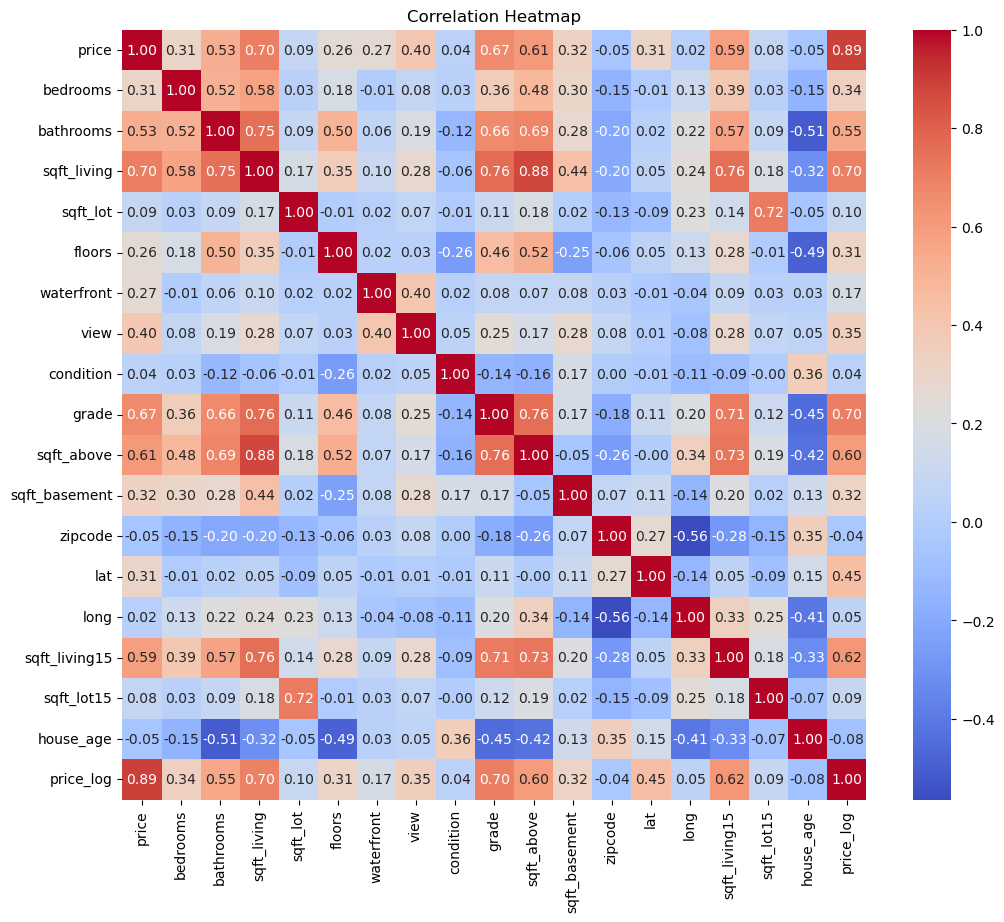

In [57]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12,10))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

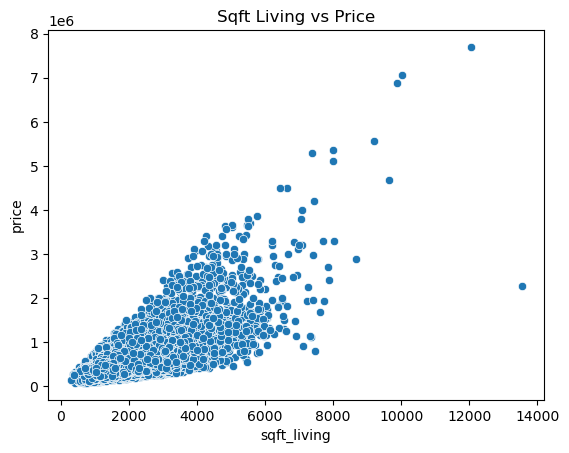

In [58]:
sns.scatterplot(x='sqft_living', y='price', data=df)
plt.title("Sqft Living vs Price")
plt.show()

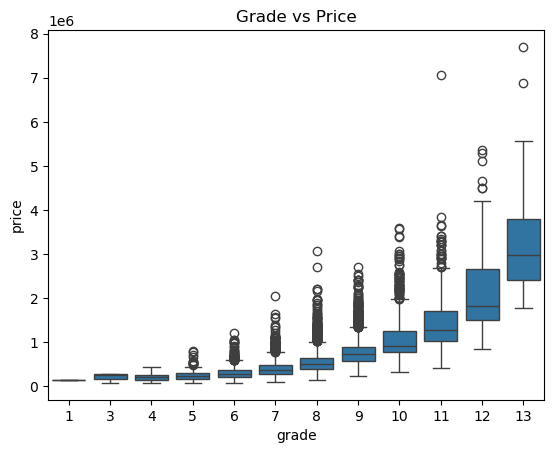

In [59]:
sns.boxplot(x='grade', y='price', data=df)
plt.title("Grade vs Price")
plt.show()

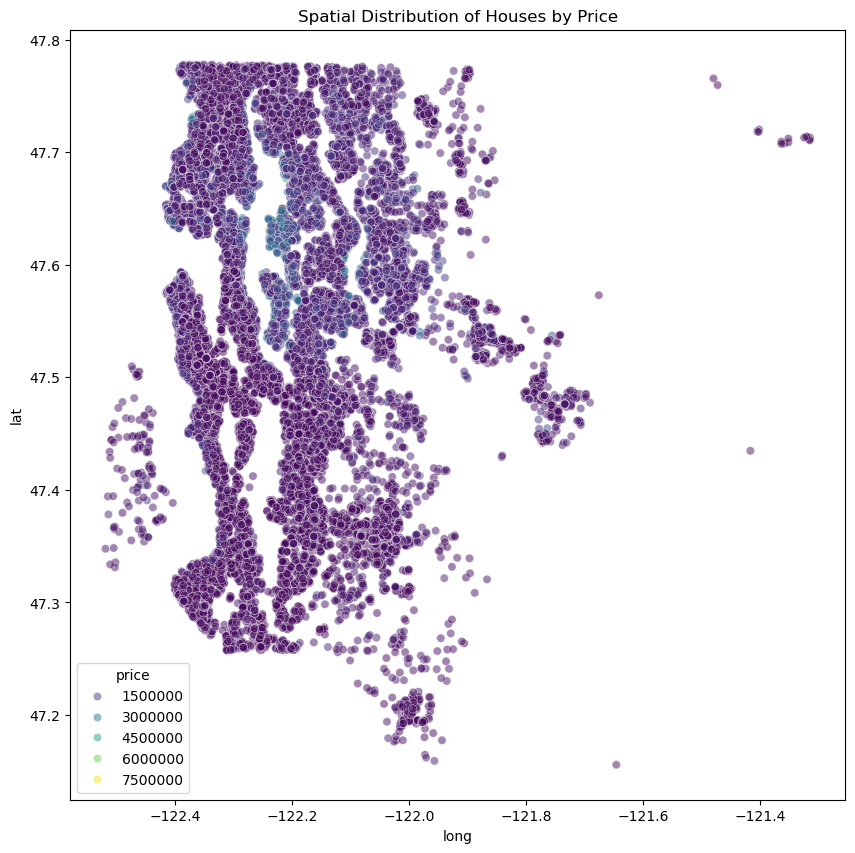

In [60]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='long', y='lat', hue='price', data=df, palette='viridis', alpha=0.5)
plt.title("Spatial Distribution of Houses by Price")
plt.show()

In [61]:
X = df.drop(['price', 'price_log'], axis=1)
y = df['price_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [63]:
y_pred_log = xgb_model.predict(X_test)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
mae_log = mean_absolute_error(y_test, y_pred_log)
print(f"Test RMSE (log scale): {rmse_log:.4f}, MAE: {mae_log:.4f}")

Test RMSE (log scale): 0.1619, MAE: 0.1159


Test RMSE (original price): $117,558.69, MAE: $65,077.40


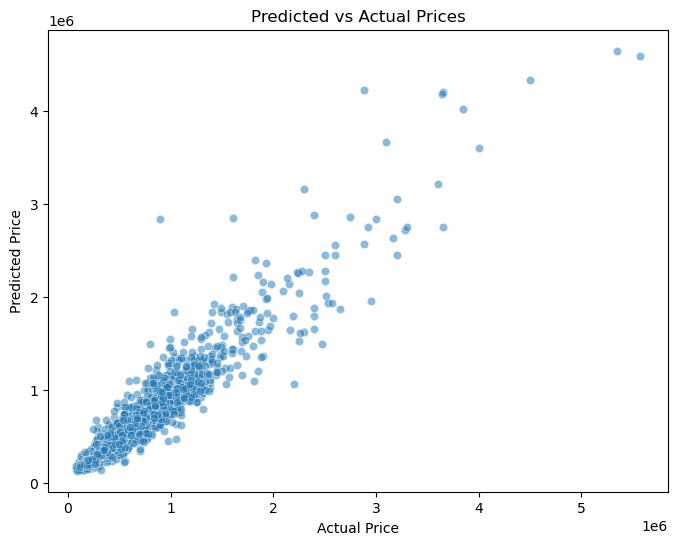

In [64]:
y_pred_orig = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test)

rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mae_orig = mean_absolute_error(y_test_orig, y_pred_orig)
print(f"Test RMSE (original price): ${rmse_orig:,.2f}, MAE: ${mae_orig:,.2f}")

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_orig, y=y_pred_orig, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices")
plt.show()

<Figure size 1000x600 with 0 Axes>

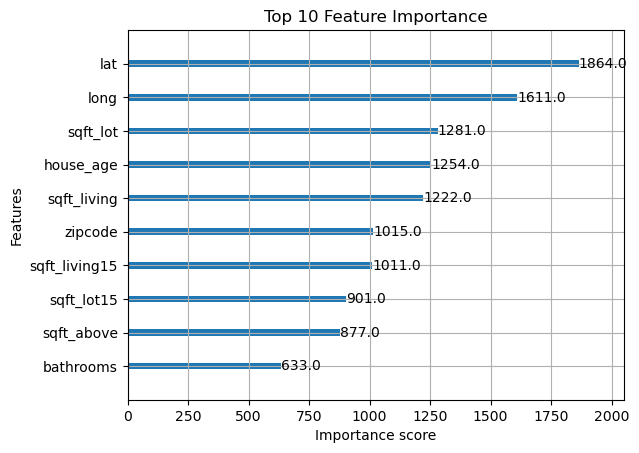

In [66]:
plt.figure(figsize=(10,6))
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("Top 10 Feature Importance")
plt.show()

In [68]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

num_rounds = 500
evals = [(dtrain, 'train'), (dtest, 'test')]

xgb_model = xgb.train(params, dtrain, num_boost_round=num_rounds, evals=evals, verbose_eval=False)

results = xgb_model.eval(dtest)
print("Final Test RMSE:", results)

results_full = xgb_model.eval(dtrain)

Final Test RMSE: [0]	eval-rmse:0.16190732993872439


In [71]:
new_house = pd.DataFrame({
    'bedrooms':[3],
    'bathrooms':[2],
    'sqft_living':[2000],
    'sqft_lot':[5000],
    'floors':[1],
    'waterfront':[0],
    'view':[0],
    'condition':[3],
    'grade':[7],
    'sqft_above':[1500],
    'sqft_basement':[500],
    'zipcode':[98105],
    'lat':[47.65],
    'long':[-122.3],
    'sqft_living15':[1800],
    'sqft_lot15':[5000],
    'house_age':[35],
    'is_renovated':[0]
})

new_house_dmatrix = xgb.DMatrix(new_house)

predicted_price_log = xgb_model.predict(new_house_dmatrix)
predicted_price = np.expm1(predicted_price_log)

print(f"Predicted Price for New House: ₹{predicted_price[0]:,.2f}")

Predicted Price for New House: ₹610,606.31
